# Profitable App Profiles for the App Store and Google Play Markets

#### A quick project in Python with an added challenge: no fancy library (only libraries used: csv, matplotlib and statistics)

## Aim

We aim to help developers understand what type of apps are likely to attract more users on Google Play and the Apple Store. We want to build revenue on ads, therefore we should look for successful apps that are free.

To minimize risks and overhead, our validation strategy for an app idea is comprised of three steps:

1) Build a minimal Android version of the app, and add it to Google Play

2) If the app has a good response from users, we develop it further

3) If the app is profitable after six months, we build an iOS version of the app and add it to the App Store

Data:
* one dataset containing statistics about approximately 7,000 iOS apps from the App Store (july 2017)

The data was originally extracted from the iTunes Search API at the Apple Inc website

The data set can be downloaded and the documentation found [here](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps/home)

Overview of variables in this first dataset:

|Column name | Description|
|:---: | :---: |
|<blank>|ID in this database|
|"id"|App ID|
|"track_name"|App Name|
|size_bytes"|Size (in Bytes)|
|"currency"|Currency type|
|"price"|Price|
|"rating_count_tot"|User Rating counts (for all version)|
|"rating_count_ver"|User Rating counts (for current version)|
|"user_rating"|Average User Rating value (for all version)|
|"user_rating_ver"|Average User Rating value (for current version)|
|"ver"|Latest version code|
|"cont_rating"|Content Rating|
|"prime_genre"|Primary Genre|
|"sup_devices.num"|Number of supporting devices|
|"ipadSc_urls.num"|Number of screenshots showed for display|
|"lang.num"|Number of supported languages|
|"vpp_lic"|Vpp Device Based Licensing Enabled|

* one dataset containing data about ~10,000 Android apps from Google play (August 2018)

The data was originally scraped from the Google Play Store

The data set can be downloaded and the documentation found [here](https://www.kaggle.com/lava18/google-play-store-apps/home)

Overview of variables in this second dataset:

|Column name|Description|
|:---:|:---:|
|App|Application name|
|Category|Category the app belongs to|
|Rating|Overall user rating of the app (as when scraped)|
|Reviews|Number of user reviews for the app (as when scraped)|
|Size|Size of the app (as when scraped)|
|Installs|Number of user downloads/installs for the app (as when scraped)|
|Type|Paid or Free|
|Price|Price of the app (as when scraped)|
|Content Rating|Age group the app is targeted at - Children / Mature 21+ / Adult|
|Genres|An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to Music, Game, Family genres.|
|Last Updated|Date when the app was last updated on Play Store (as when scraped)|
|Current Ver|Current version of the app available on Play Store (as when scraped)|
|Android Ver|Min required Android version (as when scraped)|

#### Function that prints a few lines from the dataset in a readable way

In [1]:
def explore_data(dataset, start, end, rows_and_columns=False):
    dataset_slice = dataset[start:end]    
    for row in dataset_slice:
        print(row)
        print('\n')

    if rows_and_columns:
        print('Number of rows:', len(dataset))
        print('Number of columns:', len(dataset[0]))

#### Reading the two datasets in .csv file, put them in lists (of lists), and extracting the header

Then prints a few lines of each, along with the number of apps and variables

(NB : had to manually convert .csv files to utf-8)

In [2]:
from csv import reader
file_ios=open('AppleStore.csv', encoding='utf-8')
file_android=open('googleplaystore.csv', encoding='utf-8')
apps_ios_data=list(reader(file_ios))[1:]
apps_android_data=list(reader(file_android))[1:]

explore_data(apps_ios_data, 0, 6, True)
explore_data(apps_android_data, 0, 6, True)

['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']


['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1']


['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '188583', '2822', '3.5', '4.5', '5.0.0', '4+', 'Weather', '37', '5', '3', '1']


['4', '282614216', 'eBay: Best App to Buy, Sell, Save! Online Shopping', '128512000', 'USD', '0', '262241', '649', '4', '4.5', '5.10.0', '12+', 'Shopping', '37', '5', '9', '1']


['5', '282935706', 'Bible', '92774400', 'USD', '0', '985920', '5320', '4.5', '5', '7.5.1', '4+', 'Reference', '37', '5', '45', '1']


['6', '283619399', 'Shanghai Mahjong', '10485713', 'USD', '0.99', '8253', '5516', '4', '4', '1.8', '4+', 'Games', '47', '5', '1', '1']


Number of rows: 7197
Number of columns: 17
['Photo Editor & Candy Camera & Gr

There was a report in the dataset discussion, that there is one faulty data point (missing variable). We explore the dataset until we find it, and restore the lost value (Category, gathered from Google play store)

We also look for duplicate values, and delete them based on the number of reviews they have (we keep the duplicate where we have the most reviews)

In [3]:
app_dict_clean={}
for app in apps_android_data:
    if (len(app)<13):
        app.insert(1,'LIFESTYLE')
    if ((app[0] not in app_dict_clean) or (app_dict_clean[app[0]]<app[3])):
        app_dict_clean[app[0]]=app[3]


We now have a dictionary linking all unique app names to the max number of reviews it was associated with. Next step is to iterate through this dictionary, and for each entry, find the row that corresponds to it in the Android dataset (and append it to a new list). In the end, we replace the former list and delete the list used during the cleaning for memory economy

In [4]:
apps_android_data_clean=[]
for app_clean, reviews in app_dict_clean.items():
    for app in apps_android_data:
        if (app[0]==app_clean and app[3]==reviews):
            apps_android_data_clean.append(app)
            break
apps_android_data=apps_android_data_clean
del(apps_android_data_clean)

Now, we want english-only apps. One way to check this, is to check if characters used in the app name are commonly used in the english alphabet (mainly characters whose code is <=127). We write a function that checks if a name has more than 3 such "uncommon in english" characters

In [5]:
def check_english(string):
    count_non_english_c=0
    for character in string:
        if (ord(character)>127):
            count_non_english_c+=1
    if(count_non_english_c>3):
        return(False)
    else:
        return(True)

We use this function to extract all the non-english app names (this is by no means perfect, but better than nothing)
We also, in the same loop, make sure that all the apps we extract are free apps

In [6]:
apps_android_data_clean=[]
apps_ios_data_clean=[]

for app in apps_android_data:
    if (check_english(app[0]) and app[6]=='Free'):
        apps_android_data_clean.append(app)

for app in apps_ios_data:
    if (check_english(app[2]) and float(app[5])==0):
        apps_ios_data_clean.append(app)

apps_android_data=apps_android_data_clean
apps_ios_data=apps_ios_data_clean
del(apps_android_data_clean)
del(apps_ios_data_clean)

First, let's find the most common genres for free apps in both datasets and display them

In [7]:
def freq_table(dataset, index):
    dict_freq={}
    for row in dataset:
        if row[index] in dict_freq:
            dict_freq[row[index]]+=1
        else:
            dict_freq[row[index]]=1
    for key in dict_freq:
        dict_freq[key]/=(len(dataset)/100)
    return(dict_freq)

def display_table(dataset, index):
    table = freq_table(dataset, index)
    table_display = []
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_display.append(key_val_as_tuple)

    table_sorted = sorted(table_display, reverse = True)
    for entry in table_sorted:
        print(entry[1], ':', entry[0])



In [8]:
display_table(apps_android_data, 1)

FAMILY : 18.92349356804333
GAME : 9.693071541412774
TOOLS : 8.451816745655607
BUSINESS : 4.592642744301512
LIFESTYLE : 3.9155946738885126
PRODUCTIVITY : 3.893026404874746
FINANCE : 3.7011961182577293
MEDICAL : 3.5206499661475963
SPORTS : 3.3965244865718796
PERSONALIZATION : 3.3175355450236963
COMMUNICATION : 3.238546603475513
HEALTH_AND_FITNESS : 3.080568720379147
PHOTOGRAPHY : 2.945159106296547
NEWS_AND_MAGAZINES : 2.7984653577070637
SOCIAL : 2.6630557436244637
TRAVEL_AND_LOCAL : 2.3358158429248475
SHOPPING : 2.245542766869781
BOOKS_AND_REFERENCE : 2.143985556307831
DATING : 1.8618821936357481
VIDEO_PLAYERS : 1.7941773865944481
MAPS_AND_NAVIGATION : 1.3992326788535319
FOOD_AND_DRINK : 1.2412547957571654
EDUCATION : 1.1735499887158654
ENTERTAINMENT : 0.9591514330850823
LIBRARIES_AND_DEMO : 0.9365831640713157
AUTO_AND_VEHICLES : 0.9252990295644323
HOUSE_AND_HOME : 0.8237418190024824
WEATHER : 0.8011735499887158
EVENTS : 0.7109004739336493
PARENTING : 0.6544798013992327
ART_AND_DESIGN : 

In [9]:
display_table(apps_android_data, 9)

Tools : 8.440532611148724
Entertainment : 6.070864364703227
Education : 5.348679756262694
Business : 4.592642744301512
Productivity : 3.893026404874746
Lifestyle : 3.893026404874746
Finance : 3.7011961182577293
Medical : 3.5206499661475963
Sports : 3.4642292936131795
Personalization : 3.3175355450236963
Communication : 3.238546603475513
Action : 3.1031369893929135
Health & Fitness : 3.080568720379147
Photography : 2.945159106296547
News & Magazines : 2.7984653577070637
Social : 2.6630557436244637
Travel & Local : 2.324531708417964
Shopping : 2.245542766869781
Books & Reference : 2.143985556307831
Simulation : 2.0424283457458814
Dating : 1.8618821936357481
Arcade : 1.8505980591288647
Video Players & Editors : 1.7716091175806814
Casual : 1.7490408485669149
Maps & Navigation : 1.3992326788535319
Food & Drink : 1.2412547957571654
Puzzle : 1.128413450688332
Racing : 0.9930038366057323
Role Playing : 0.9365831640713157
Libraries & Demo : 0.9365831640713157
Auto & Vehicles : 0.925299029564432

In [10]:
display_table(apps_ios_data, 12)

Games : 58.16263190564867
Entertainment : 7.883302296710118
Photo & Video : 4.9658597144630665
Education : 3.6623215394165114
Social Networking : 3.289882060831782
Shopping : 2.60707635009311
Utilities : 2.5139664804469275
Sports : 2.1415270018621975
Music : 2.048417132216015
Health & Fitness : 2.017380509000621
Productivity : 1.7380509000620734
Lifestyle : 1.5828677839851024
News : 1.3345747982619491
Travel : 1.2414649286157666
Finance : 1.1173184357541899
Weather : 0.8690254500310367
Food & Drink : 0.8069522036002483
Reference : 0.5586592178770949
Business : 0.5276225946617008
Book : 0.43451272501551835
Navigation : 0.186219739292365
Medical : 0.186219739292365
Catalogs : 0.12414649286157667


Now let's get a finer view, and instead of thinking in terms of frequency of the apps' genres, let's see how many users we have per category on average

In [17]:
ios_genres=freq_table(apps_ios_data, 12) #Just to get the keys, that are unique genres

list_genres_users_ios=[]
for genre in ios_genres:
    total=0
    len_genre=0
    for app in apps_ios_data:
        if (app[12] == genre):
            len_genre+=1
            total+=float(app[6])
    list_genres_users_ios.append((total/len_genre, genre))
list_genres_users_ios=sorted(list_genres_users_ios, reverse=True)
for genre in list_genres_users_ios:
    print(genre[1] + ': ' + str(genre[0]))

Navigation: 86090.33333333333
Reference: 74942.11111111111
Social Networking: 71548.34905660378
Music: 57326.530303030304
Weather: 52279.892857142855
Book: 39758.5
Food & Drink: 33333.92307692308
Finance: 31467.944444444445
Photo & Video: 28441.54375
Travel: 28243.8
Shopping: 26919.690476190477
Health & Fitness: 23298.015384615384
Sports: 23008.898550724636
Games: 22788.6696905016
News: 21248.023255813954
Productivity: 21028.410714285714
Utilities: 18684.456790123455
Lifestyle: 16485.764705882353
Entertainment: 14029.830708661417
Business: 7491.117647058823
Education: 7003.983050847458
Catalogs: 4004.0
Medical: 612.0


We can clearly see here that even if games are (by far) the most common type of app on Apple Store, they don't have a great average of users compared to other softwares. It may therefore be worth investigating other types of software, but we should first see if the trend is similar on Google Play (let's just focus on the main category)

In [19]:
android_genres=freq_table(apps_android_data, 1)
list_genres_users_android=[]
for genre in android_genres:
    total=0
    len_genre=0
    for app in apps_android_data:
        if (app[1] == genre):
            len_genre+=1
            total+=float(app[5].replace('+','').replace(',',''))
    list_genres_users_android.append((total/len_genre, genre))
list_genres_users_android=sorted(list_genres_users_android, reverse=True)
for genre in list_genres_users_android:
    print(genre[1] + ': ' + str(genre[0]))

COMMUNICATION: 38456119.167247385
VIDEO_PLAYERS: 24727872.452830188
SOCIAL: 23253652.127118643
PHOTOGRAPHY: 17805627.643678162
PRODUCTIVITY: 16787331.344927534
GAME: 15560965.599534342
TRAVEL_AND_LOCAL: 13984077.710144928
ENTERTAINMENT: 11640705.88235294
TOOLS: 10682301.033377837
NEWS_AND_MAGAZINES: 9549178.467741935
BOOKS_AND_REFERENCE: 8767811.894736841
SHOPPING: 7036877.311557789
PERSONALIZATION: 5201482.6122448975
WEATHER: 5074486.197183099
HEALTH_AND_FITNESS: 4188821.9853479853
MAPS_AND_NAVIGATION: 4056941.7741935486
FAMILY: 3696479.242695289
SPORTS: 3638640.1428571427
ART_AND_DESIGN: 1986335.0877192982
FOOD_AND_DRINK: 1924897.7363636363
EDUCATION: 1820673.076923077
BUSINESS: 1712290.1474201474
LIFESTYLE: 1433675.5878962537
FINANCE: 1387692.475609756
HOUSE_AND_HOME: 1331540.5616438356
DATING: 854028.8303030303
COMICS: 817657.2727272727
AUTO_AND_VEHICLES: 647317.8170731707
LIBRARIES_AND_DEMO: 638503.734939759
PARENTING: 542603.6206896552
BEAUTY: 513151.88679245283
EVENTS: 253542.22

Let's look at the first 6 ones, that look promising

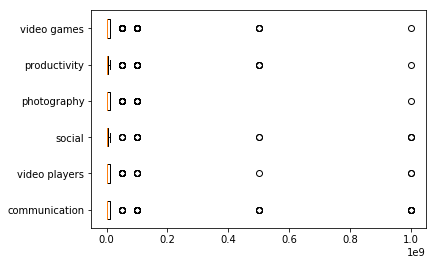

In [38]:
import matplotlib.pyplot as plt

total_communication=[]
total_video=[]
total_social=[]
total_photo=[]
total_productivity=[]
total_game=[]
for app in apps_android_data:
    if (app[1] == "COMMUNICATION"):
        total_communication.append(float(app[5].replace('+','').replace(',','')))
    elif (app[1] == "VIDEO_PLAYERS"):
        total_video.append(float(app[5].replace('+','').replace(',','')))
    elif (app[1] == "SOCIAL"):
        total_social.append(float(app[5].replace('+','').replace(',','')))
    elif (app[1] == "PHOTOGRAPHY"):
        total_photo.append(float(app[5].replace('+','').replace(',','')))
    elif (app[1] == "PRODUCTIVITY"):
        total_productivity.append(float(app[5].replace('+','').replace(',','')))
    elif (app[1] == "GAME"):
        total_game.append(float(app[5].replace('+','').replace(',','')))

rt=plt.boxplot([total_communication, total_video, total_social, total_photo, total_productivity, total_game], labels=['communication', 'video players', 'social', 'photography', 'productivity', 'video games'], vert=0)

Ok. So there seems to be a small problem here : all distributions of any genre of interest are incredibly skewed by strong outliers. It may be worth investigating what those outliers are (even if some of them seem rather obvious) and see if there is still a reachable market there

Messenger – Text and Video Chat for Free: 1.00e+09
WhatsApp Messenger: 1.00e+09
Messenger for SMS: 1.00e+07
Google Chrome: Fast & Secure: 1.00e+09
Messenger Lite: Free Calls & Messages: 1.00e+08
Gmail: 1.00e+09
Hangouts: 1.00e+09
Viber Messenger: 5.00e+08
Firefox Browser fast & private: 1.00e+08
Yahoo Mail – Stay Organized: 1.00e+08
imo beta free calls and text: 1.00e+08
imo free video calls and chat: 5.00e+08
Contacts: 5.00e+07
Opera Mini - fast web browser: 1.00e+08
Browser 4G: 1.00e+07
MegaFon Dashboard: 1.00e+07
ZenUI Dialer & Contacts: 1.00e+07
Cricket Visual Voicemail: 1.00e+07
Opera Browser: Fast and Secure: 1.00e+08
Google Voice: 1.00e+07
Xperia Link™: 1.00e+07
TouchPal Keyboard - Fun Emoji & Android Keyboard: 1.00e+07
Who: 1.00e+08
WeChat: 1.00e+08
UC Browser Mini -Tiny Fast Private & Secure: 1.00e+08
WhatsApp Business: 1.00e+07
Android Messages: 1.00e+08
Telegram: 1.00e+08
Google Duo - High Quality Video Calls: 5.00e+08
Puffin Web Browser: 1.00e+07
AT&T Visual Voicemail: 1.00

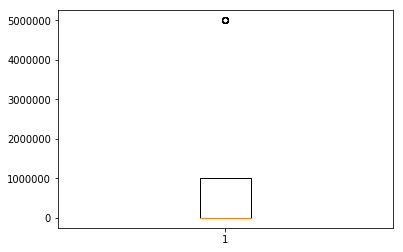

In [79]:
import statistics as stats
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "COMMUNICATION" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_communication=[i for i in total_communication if i<1e7]
rt=plt.boxplot([total_communication])
print(stats.median(total_communication))

This seems like a very hard market to enter. It is dominated by giants like Google and Facebook, and half of these softwares have no more than 10000 users

YouTube: 1.00e+09
Video Downloader: 1.00e+07
Motorola FM Radio: 1.00e+08
Video Player All Format: 1.00e+07
Motorola Gallery: 1.00e+08
VLC for Android: 1.00e+08
Code: 1.00e+07
Vote for: 5.00e+07
Music - Mp3 Player: 1.00e+07
YouTube Studio: 1.00e+07
video player for android: 1.00e+07
Vigo Video: 5.00e+07
Google Play Movies & TV: 1.00e+09
HTC Service － DLNA: 1.00e+07
MiniMovie - Free Video and Slideshow Editor: 5.00e+07
Samsung Video Library: 5.00e+07
LIKE – Magic Video Maker & Community: 5.00e+07
HTC Gallery: 1.00e+07
PowerDirector Video Editor App: 4K, Slow Mo & More: 1.00e+07
Cartoon Network App: 1.00e+07
MX Player: 5.00e+08
Omlet Arcade - Stream, Meet, Play: 1.00e+07
Magisto Video Editor & Maker: 1.00e+07
Dubsmash: 1.00e+08
DU Recorder – Screen Recorder, Video Editor, Live: 5.00e+07
KineMaster – Pro Video Editor: 5.00e+07
Mobizen Screen Recorder for SAMSUNG: 1.00e+07
Ustream: 1.00e+07
VMate: 5.00e+07
All Video Downloader: 1.00e+07
HD Video Downloader : 2018 Best video mate: 5.00e+07
V

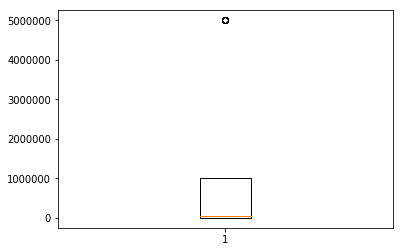

In [80]:
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "VIDEO_PLAYERS" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_video=[i for i in total_video if i<1e7]
rt=plt.boxplot([total_video])
print(stats.median(total_video))

Same problem here, even if the median is slightly higher.

Facebook: 1.00e+09
Instagram: 1.00e+09
Facebook Lite: 5.00e+08
Messages, Text and Video Chat for Messenger: 1.00e+07
Tumblr: 1.00e+08
Snapchat: 5.00e+08
Pinterest: 1.00e+08
TextNow - free text + calls: 1.00e+07
Google+: 1.00e+09
LiveMe - Video chat, new friends, and make money: 1.00e+07
Amino: Communities and Chats: 1.00e+07
Phone Tracker : Family Locator: 1.00e+07
HTC Social Plugin - Facebook: 1.00e+07
Periscope - Live Video: 1.00e+07
Quora: 1.00e+07
Kate Mobile for VK: 1.00e+07
LinkedIn: 1.00e+08
Text Me: Text Free, Call Free, Second Phone Number: 1.00e+07
Badoo - Free Chat & Dating App: 1.00e+08
Text free - Free Text + Call: 1.00e+07
textPlus: Free Text & Calls: 1.00e+07
Free phone calls, free texting SMS on free number: 1.00e+07
Tango - Live Video Broadcast: 1.00e+08
MeetMe: Chat & Meet New People: 5.00e+07
Tagged - Meet, Chat & Dating: 1.00e+07
ooVoo Video Calls, Messaging & Stories: 5.00e+07
SayHi Chat, Meet New People: 1.00e+07
Tapatalk - 100,000+ Forums: 1.00e+07
YouNow: Live S

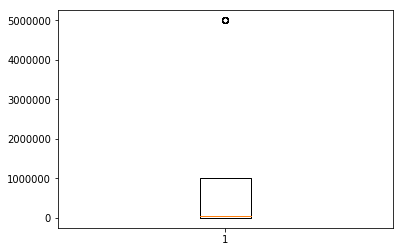

In [83]:
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "SOCIAL" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_social=[i for i in total_social if i<1e7]
rt=plt.boxplot([total_social])
print(stats.median(total_social))

Google Photos: 1.00e+09
Motorola Camera: 5.00e+07
Face Filter, Selfie Editor - Sweet Camera: 1.00e+07
LightX Photo Editor & Photo Effects: 1.00e+07
Sweet Snap - live filter, Selfie photo edit: 1.00e+07
Adobe Photoshop Express:Photo Editor Collage Maker: 5.00e+07
B612 - Beauty & Filter Camera: 1.00e+08
InstaBeauty -Makeup Selfie Cam: 5.00e+07
Photo Frame: 1.00e+07
Camera360 Lite - Selfie Camera: 1.00e+07
Selfie Camera - Photo Editor & Filter & Sticker: 5.00e+07
YouCam Makeup - Magic Selfie Makeovers: 1.00e+08
BeautyPlus - Easy Photo Editor & Selfie Camera: 1.00e+08
ASUS Gallery: 5.00e+07
My Photo Keyboard: 1.00e+07
Photo Collage - Layout Editor: 1.00e+07
Sweet Camera - Selfie Filters, Beauty Camera: 1.00e+07
Photo Frames: 1.00e+07
Sweet Selfie - selfie camera, beauty cam, photo edit: 1.00e+08
Candy selfie - photo editor, live filter camera: 1.00e+07
YouCam Perfect - Selfie Photo Editor: 1.00e+08
Open Camera: 1.00e+07
QuickPic - Photo Gallery with Google Drive Support: 1.00e+07
Flickr: 1

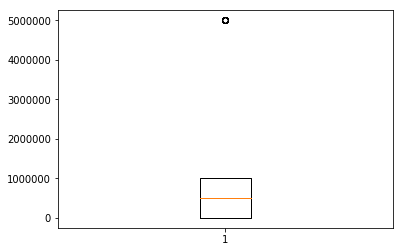

In [84]:
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "PHOTOGRAPHY" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_photo=[i for i in total_photo if i<1e7]
rt=plt.boxplot([total_photo])
print(stats.median(total_photo))

We have here what seems to be the first approachable market. While still dominated by giants like Google or Instagram, it seems people are open to alternatives (as shown by a median of 500,000 people). And judging  by the kind of apps that are represented here, it would seem it would not require a strong budget and a big technical team to make an app that has some success (maybe a convenient editing or filter software for social networks?)

Probably that one of the reasons this seems accessible is because contrarily to former apps, these are not mutually exlusive. For instance you rarely use more than 5 social networking platforms, while it is not a problem to use different photography editing softwares if they all have their own fun thing to offer

Microsoft Word: 5.00e+08
All-In-One Toolbox: Cleaner, Booster, App Manager: 1.00e+07
Adobe Acrobat Reader: 1.00e+08
AVG Cleaner – Speed, Battery & Memory Booster: 1.00e+07
Google Drive: 1.00e+09
QR Scanner & Barcode Scanner 2018: 1.00e+07
Chrome Beta: 1.00e+07
Microsoft Outlook: 1.00e+08
Google PDF Viewer: 1.00e+07
Microsoft Excel: 1.00e+08
Google Assistant: 1.00e+07
Microsoft OneDrive: 1.00e+08
Calculator - unit converter: 5.00e+07
Microsoft OneNote: 1.00e+08
Metro name iD: 1.00e+07
Google Keep: 1.00e+08
ES File Explorer File Manager: 1.00e+08
ASUS SuperNote: 1.00e+07
HTC File Manager: 1.00e+07
Dropbox: 5.00e+08
ASUS Quick Memo: 1.00e+07
HTC Calendar: 1.00e+07
Google Calendar: 5.00e+08
Google Docs: 1.00e+08
ASUS Calling Screen: 1.00e+07
Evernote – Organizer, Planner for Notes & Memos: 1.00e+08
HTC Mail: 1.00e+07
Advanced Task Killer: 5.00e+07
MyVodafone (India) - Online Recharge & Pay Bills: 1.00e+07
Microsoft PowerPoint: 1.00e+08
My Airtel-Online Recharge, Pay Bill, Wallet, UPI: 5.00

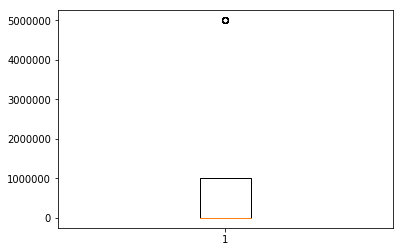

In [85]:
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "PRODUCTIVITY" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_productivity=[i for i in total_productivity if i<1e7]
rt=plt.boxplot([total_productivity])
print(stats.median(total_productivity))

Subway Surfers: 1.00e+09
Candy Crush Saga: 5.00e+08
slither.io: 1.00e+08
Clash Royale: 1.00e+08
Temple Run 2: 5.00e+08
Pou: 5.00e+08
Helix Jump: 1.00e+08
Angry Birds Rio: 1.00e+08
Plants vs. Zombies FREE: 1.00e+08
Sonic Dash: 1.00e+08
Candy Crush Soda Saga: 1.00e+08
Clash of Clans: 1.00e+08
Kick the Buddy: 5.00e+07
PAC-MAN: 1.00e+08
8 Ball Pool: 1.00e+08
Magic Tiles 3: 5.00e+07
Bubble Witch 3 Saga: 5.00e+07
Word Search: 5.00e+07
Granny: 5.00e+07
Angry Birds Classic: 1.00e+08
Flow Free: 1.00e+08
Race the Traffic Moto: 1.00e+07
Fishdom: 1.00e+07
Galaxy Attack: Alien Shooter: 1.00e+07
Zombie Tsunami: 1.00e+08
Candy Crush Jelly Saga: 5.00e+07
Hill Climb Racing: 1.00e+08
Gardenscapes: 5.00e+07
Marble - Temple Quest: 1.00e+07
Shooting King: 1.00e+07
Zombie Catchers: 1.00e+07
Geometry Dash World: 1.00e+07
My Talking Angela: 1.00e+08
Cut the Rope FULL FREE: 1.00e+08
Sniper 3D Gun Shooter: Free Shooting Games - FPS: 1.00e+08
Cooking Fever: 1.00e+08
Toon Blast: 1.00e+07
Score! Hero: 1.00e+08
Toy

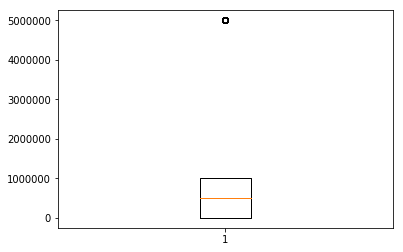

In [86]:
for app in apps_android_data:
    users=float(app[5].replace('+','').replace(',',''))
    if (app[1] == "GAME" and users>=1e7):
        print(app[0] + ': ' + '{:.2e}'.format(users))
total_game=[i for i in total_game if i<1e7]
rt=plt.boxplot([total_game])
print(stats.median(total_game))

This seems like another possible market, and it looks like the outliers are not dominated by very few industries so a good technical and marketing team might even possibly hope to get to these heights (for the same reasons mentioned above: the video game market is not exclusive)

One of the strongest limits of this quick analysis is that the number of installs is not necessarily in line with the regularity of use (which is a problem if we count on advertising for revenue). Unfortunately, we don't have the data for a fine analysis on the subject. I would still now recommend seeing what is feasible in terms of technique and marketing before going further, as this would strongly condition what kind of things we want to dive into. But with this quick analysis, I would recommend choosing **photography editing** or **games** softwares